In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import altair as alt
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils/')

# Look at available variables

In [4]:
dir_example='/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0015_PI_SOM_v02/atm/hist'
ds_h0=xr.open_dataset(dir_example+'/COUP0015_PI_SOM_v02.cam.h0.0108-09.nc')
ds_h1=xr.open_dataset(dir_example+'/COUP0015_PI_SOM_v02.cam.h1.0063-02.nc')
ds_h2=xr.open_dataset(dir_example+'/COUP0015_PI_SOM_v02.cam.h2.0087-01-02-00000.nc')

In [5]:
for var in ds_h1.variables:
    print(var)

lat
lon
gw
lev
hyam
hybm
P0
ilev
hyai
hybi
time
date
datesec
time_bnds
date_written
time_written
ndbase
nsbase
nbdate
nbsec
mdt
ndcur
nscur
co2vmr
ch4vmr
n2ovmr
f11vmr
f12vmr
sol_tsi
nsteph
CLDTOT
CLOUD
CLOUDCOVER_CLUBB
CLOUDFRAC_CLUBB
FLNS
FLNSC
FLNT
FLNTC
FLNTCLR
FLUTC
FSDSC
FSNS
FSNSC
FSNT
FSNTC
FSNTOA
FSNTOAC
H2O
H2O_SRF
LHFLX
LWCF
Q
QFLX
QREFHT
SHFLX
SWCF
T
TREFHT
TS
TSMN
TSMX


In [6]:
for i, var in enumerate(ds_h0.variables):
    if i>15:
        print(var)
        print(ds_h0[var].attrs['long_name'])
        print('-----------')

ndbase
base day
-----------
nsbase
seconds of base day
-----------
nbdate
base date (YYYYMMDD)
-----------
nbsec
seconds of base date
-----------
mdt
timestep
-----------
ndcur
current day (from base day)
-----------
nscur
current seconds of current day
-----------
co2vmr
co2 volume mixing ratio
-----------
ch4vmr
ch4 volume mixing ratio
-----------
n2ovmr
n2o volume mixing ratio
-----------
f11vmr
f11 volume mixing ratio
-----------
f12vmr
f12 volume mixing ratio
-----------
sol_tsi
total solar irradiance
-----------
nsteph
current timestep
-----------
ADRAIN
Average rain effective Diameter
-----------
ADSNOW
Average snow effective Diameter
-----------
AEROD_v
Total Aerosol Optical Depth in visible band
-----------
ANRAIN
Average rain number conc
-----------
ANSNOW
Average snow number conc
-----------
AODDUST
Aerosol optical depth 550 nm from dust, day only
-----------
AODDUST1
Aerosol optical depth, day only, 550 nm mode 1 from dust
-----------
AODDUST3
Aerosol optical depth, day onl

# Load grid cell information

In [7]:
from load_gridcell_areas import *

In [8]:
ds_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/'+
                           'COUP0000_PI_SOM'+
                           '/lnd/hist/'+
                           'COUP0000_PI_SOM.clm2.h0.0049-02-01-00000.nc')

In [9]:
landfrac=ds_lnd.landfrac

In [10]:
landfrac=landfrac.reindex_like(ds_h0, method='nearest', tolerance=0.05)

In [11]:
area=ds_lnd.area.reindex_like(ds_h0, method='nearest', tolerance=0.05)

In [12]:
landarea=(landfrac*area)
landweights=landarea/np.nanmean(landarea)

glc_frac=ds_lnd.PCT_LANDUNIT[0,3,:,:]/100
nonglac_landarea=(landfrac*(1-glc_frac))*area
landweights_nonglac=nonglac_landarea/np.nanmean(nonglac_landarea)

In [13]:
landweights_arctic=subset_landweights(latmax=100, latmin=60)

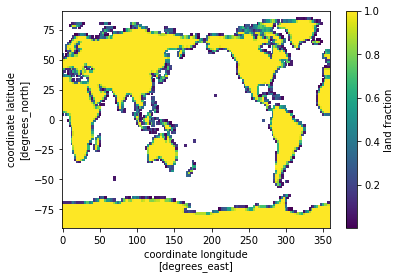

In [14]:
landfrac.plot()

In [15]:
area=ds_lnd.area.reindex_like(ds_h0, method='nearest', tolerance=0.01)
areaweights=area/area.sum(dim=['lat','lon'])
gridweights=ds_h0.gw/np.mean(ds_h0.gw)

In [16]:
landweights_arctic=landweights_arctic.reindex_like(gridweights, method='nearest', tolerance=0.01)

# Load data

In [17]:
from load_ensembles import *

In [26]:
var='TSKIN'
h='h0'

In [27]:
basecase_lnd=xr.open_dataset('/glade/campaign/cgd/tss/czarakas/CoupledPPE/coupled_simulations/COUP0000_PI_SOM/lnd/proc/tseries/COUP0000_PI_SOM.clm2.'+
                             h+'.timeseries.'+var+'.nc')

In [28]:
ref=basecase_lnd[var][12*60:,:,:].mean(dim='time')
ref_tseries=basecase_lnd[var][12*60:,:,:].groupby('time.year').mean(dim='time')

In [29]:
ensemble_coupled=load_coupled_ensemble(var=var, domain='lnd')

In [30]:
ref_avg=ref_tseries.where(landfrac>0.99).mean(dim='year')

In [31]:
def get_gridded_average(ds):
    tseries=ds[var][12*60:,:,:].groupby('time.year').mean(dim='time')
    avg=ds[var][12*60:,:,:].mean(dim='time')-ref
    
    t, p = ttest_ind(tseries, ref_tseries, equal_var=False)
    
    return [avg, p]

In [32]:
def get_tseries_mean(ds):
    tseries_mean=ds[var][12*60:,:,:].groupby('time.year').mean(dim='time')
    
    return tseries_mean

# Calculate range of global mean metrics

In [33]:
weights=gridweights
ref_comparison = (ref*weights).mean(dim=['lat','lon']).values-273.15
global_temps=[]
for i, ds in enumerate(ensemble_coupled):
    #print(i)
    global_mean = (ds[var][12*60:,:,:]*weights).mean(dim=['lat','lon','time']).values-273.15
    global_temps.append(global_mean-ref_comparison)

In [34]:
weights=landweights
ref_comparison = (ref*weights).mean(dim=['lat','lon']).values-273.15
global_land_temps=[]
for i, ds in enumerate(ensemble_coupled):
    #print(i)
    global_mean = (ds[var][12*60:,:,:]*weights).mean(dim=['lat','lon','time']).values-273.15
    global_land_temps.append(global_mean-ref_comparison)

In [35]:
weights=landweights_nonglac
global_nonglacland_temps=[]
ref_comparison = (ref*weights).mean(dim=['lat','lon']).values-273.15
for i, ds in enumerate(ensemble_coupled):
    #print(i)
    global_mean = (ds[var][12*60:,:,:]*weights).mean(dim=['lat','lon','time']).values-273.15
    global_nonglacland_temps.append(global_mean-ref_comparison)

KeyboardInterrupt: 

In [ ]:
print(np.nanmax(global_temps)-np.nanmin(global_temps))
print(np.nanmax(global_land_temps)-np.nanmin(global_land_temps))
print(np.nanmax(global_nonglacland_temps)-np.nanmin(global_nonglacland_temps))

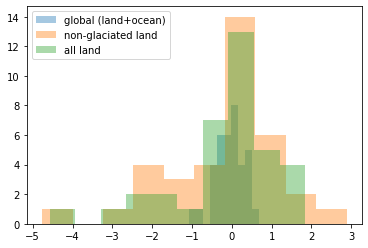

In [31]:
plt.hist(np.array(global_temps), label='global (land+ocean)', alpha=0.4)
plt.hist(np.array(global_nonglacland_temps), label='non-glaciated land', alpha=0.4)
plt.hist(np.array(global_land_temps), label='all land', alpha=0.4)
plt.legend()

In [36]:
#crosswalk['global_nonglacland_temp']=global_nonglacland_temps
crosswalk['global_temp']=global_temps

ValueError: Length of values does not match length of index

In [33]:
minval=np.nanmin([np.nanmin(crosswalk['global_nonglacland_temp'].values),
                 np.nanmin(crosswalk['global_nonglacland_temp'].values)])

In [ ]:
colors = ['black','teal','brown','lightskyblue','orange','green','dodgerblue','red',
         'grey','mediumblue']

#manual_ordered = manual_ordered.sort_values(['col', 'index'], ascending=[False, True])
source = crosswalk
points=alt.Chart(source).mark_bar(filled=True).encode(
    x=alt.X('param', sort=alt.SortField(field="parameter category",
                                        order='descending')),#, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y('global_nonglacland_temp'),#,scale=alt.Scale(domain=[minval, maxval])),
    #opacity='parameter domain',
    color=alt.Color('parameter category', scale=alt.Scale(range=colors)),
    #opacity='minmax',
    tooltip=['param', 
             'parameter description',
             'parameter domain', 
             'parameter category', 
             #'global_nonglacland_temp'
             'minmax']
)#.interactive()

points
#plt.savefig('altairchart.png')

In [ ]:
import altair as alt
source = crosswalk

x_var='global_nonglacland_temp'
y_var='global_temp'

minval=np.nanmin([np.nanmin(crosswalk[x_var].values),
                 np.nanmin(crosswalk[y_var].values)])-0.2
maxval=np.nanmax([np.nanmax(crosswalk[x_var].values),
                 np.nanmax(crosswalk[y_var].values)])+0.2

alt.Chart(source).mark_point(size=60).encode(
    x=alt.X(x_var, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y(y_var,scale=alt.Scale(domain=[minval, maxval])),
    #opacity='parameter domain',
    color='parameter domain',
    tooltip=['param', 
             'parameter description',
             'parameter domain', 
             'parameter category', 
             'minmax']
).interactive()

#plt.scatter(np.array(global_nonglacland_temps),
#         np.array(global_temps),c=crosswalk['parameter domain'])

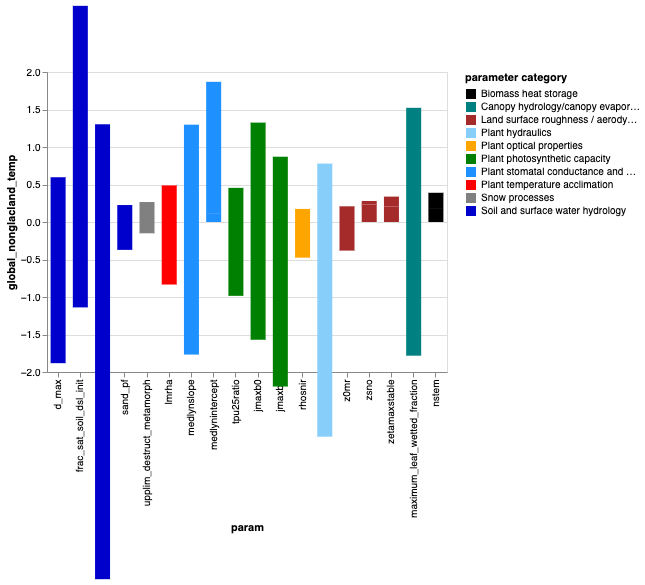

In [36]:
colors = ['black','teal','brown','lightskyblue','orange','green','dodgerblue','red',
         'grey','mediumblue']

#manual_ordered = manual_ordered.sort_values(['col', 'index'], ascending=[False, True])
source = crosswalk


lines=alt.Chart(source).mark_line().encode(
    x=alt.X('param', sort=alt.SortField(field="parameter category",
                                        order='descending')),#, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y('global_nonglacland_temp',scale=alt.Scale(domain=[minval, maxval]))
)#.interactive()

points=alt.Chart(source).mark_bar(filled=True, size=15).encode(
    x=alt.X('param', sort=alt.SortField(field="parameter category",
                                        order='descending')),#, scale=alt.Scale(domain=[minval, maxval])),
    y=alt.Y('global_nonglacland_temp',scale=alt.Scale(domain=[-2, 2])),
    #opacity='parameter domain',
    color=alt.Color('parameter category', scale=alt.Scale(range=colors)),
    shape='minmax',
    tooltip=['param', 
             'parameter description',
             'parameter domain', 
             'parameter category', 
             'minmax']
)#.interactive()

points

# Plot Timeseries of global mean

In [ ]:
ref_tseries_all=basecase_lnd[var][:,:,:].groupby('time.year').mean(dim='time')
ref_tseries_global=(ref_tseries_all*gridweights).mean(dim=['lat','lon'])-273.15
ref_tseries_global_smooth=ref_tseries_global.rolling(year=1).mean()

In [ ]:
plt.figure(figsize=(10,7))
for i in np.arange(0,35):
    print(i)
    ds=ensemble_coupled[i]
    tseries=ds[var][:,:,:].groupby('time.year').mean(dim='time')
    tseries_global=(tseries*gridweights).mean(dim=['lat','lon'])-273.15
    tseries_global_smooth=tseries_global.load().rolling(year=1).mean()
    plt.plot(tseries_global_smooth ,'-k', label=crosswalk['description'].values[i], alpha=0.3)
plt.plot(ref_tseries_global_smooth,'-k', label='reference')
#plt.legend(ncol=4, fontsize=6)

In [ ]:
unitconv=1#86400*365*1000
plt.figure(figsize=(10,7))
ref_tseries_zonal=(ref_tseries.where(landfrac>0.99)).mean(dim=['year','lon'])*unitconv
for i in np.arange(0,35):
    print(i)
    ds=ensemble_coupled[i]
    tseries=ds[var][60*12:,:,:].groupby('time.year').mean(dim='time')
    tseries_zonal=(tseries.where(landfrac>0.99)).mean(dim=['year','lon'])*unitconv
    tseries_zonal_diff=tseries_zonal-ref_tseries_zonal
    plt.plot(ref_tseries_zonal.lat, tseries_zonal_diff ,'-k', label=crosswalk['description'].values[i], alpha=0.3)
#plt.plot(ref_tseries_global,'-k', label='reference')
plt.grid()
#plt.legend(ncol=4, fontsize=6)

# Plot map of differences from default case

In [37]:
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'gray'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


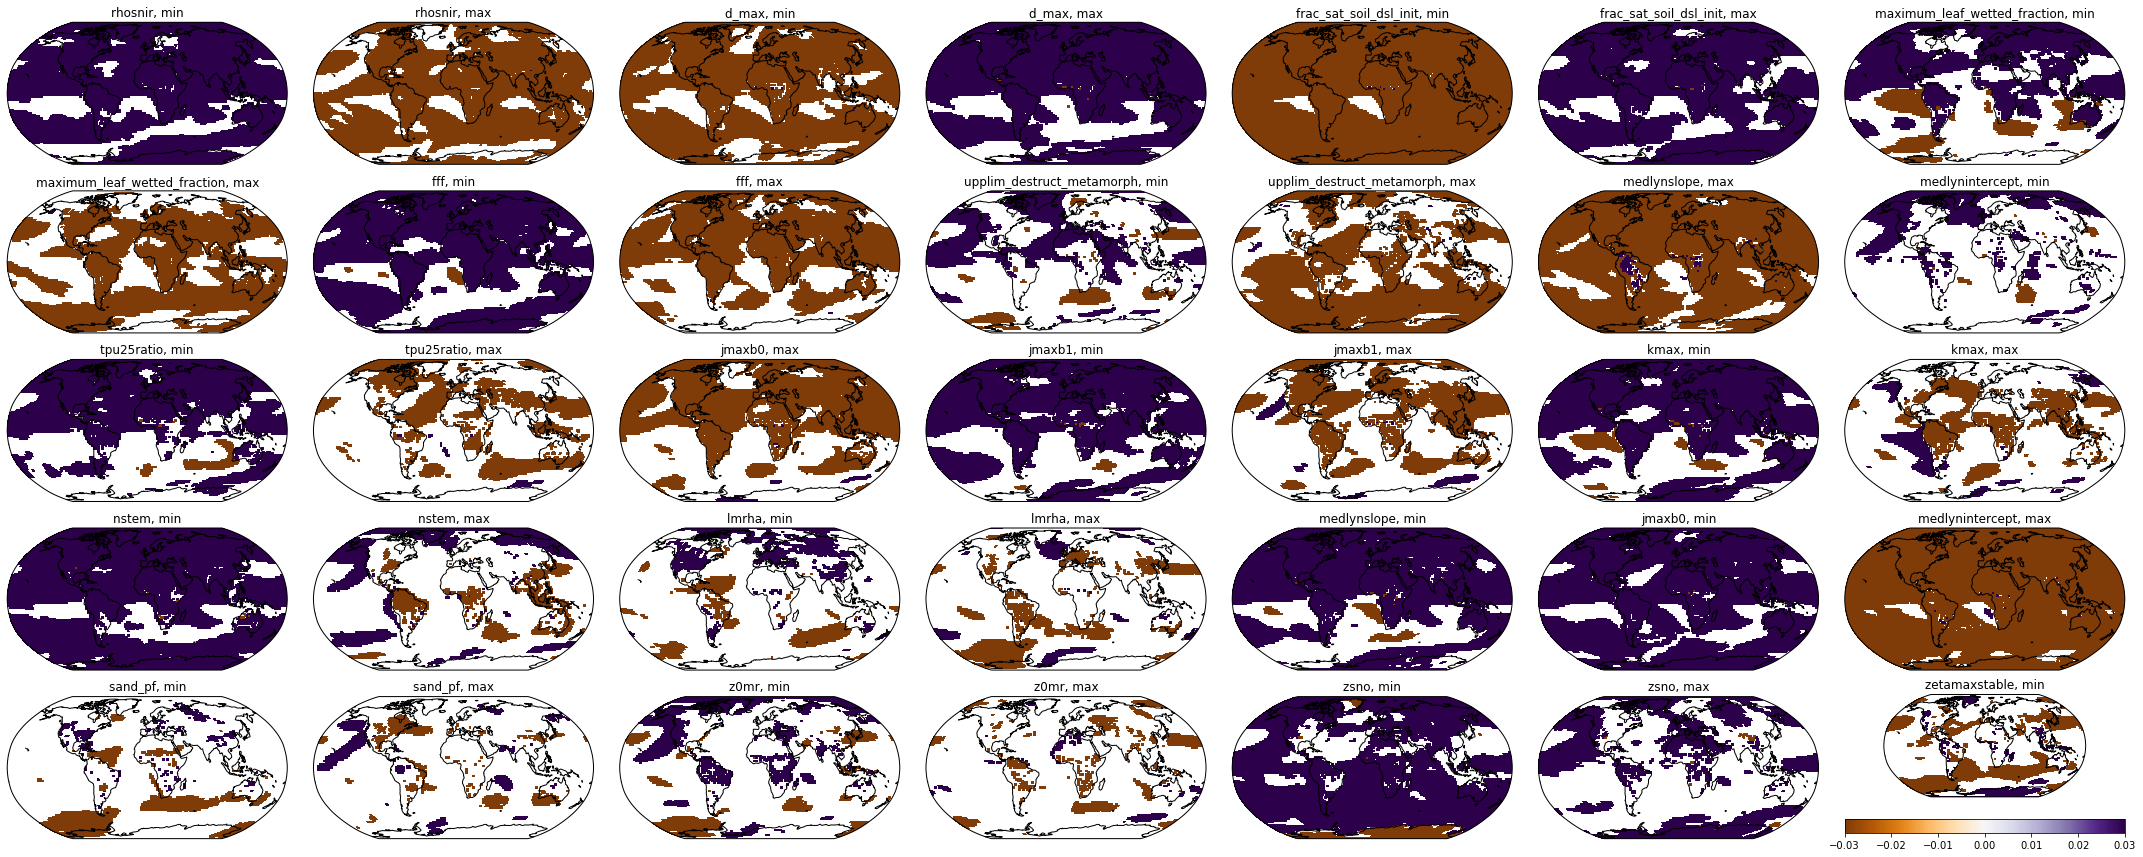

In [38]:
plt.figure(figsize=(30,12))
sig_option = 'sig_only' #'show_insig_stipple'
sig_cutoff=0.05
cmap=plt.cm.PuOr
vmin=-0.03
vmax=0.03
unitconv=1#86400*365*1000
for i in np.arange(0,35):
    print(i)
    ax=plt.subplot(5,7,i+1,projection=ccrs.Robinson())
    ds=ensemble_coupled[i]
    [avg, p]=get_gridded_average(ds)
    ax.coastlines()
    ax.set_global()
    avg_conv=avg*unitconv
    
    if np.nanmax(avg)==0:
        if np.nanmin(avg)==0:
            print("Exactly the same")
            
    cyclic_data, cyclic_lons = add_cyclic_point(avg_conv, 
                                                coord=avg_conv.lon)
    
    if sig_option=='show_all':
        # show deltas everywhere
        cs=plt.pcolormesh(cyclic_lons, 
                          avg.lat, 
                          cyclic_data, 
                          cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        if i==34:
            plt.colorbar(orientation='horizontal')
    
    elif sig_option=='sig_only':
        # only show deltas that are statistically significantly different from default
        cyclic_data_sig, cyclic_lons = add_cyclic_point(avg_conv.where(p<sig_cutoff), coord=avg.lon)
        cs=plt.pcolormesh(cyclic_lons, 
                          avg.lat, 
                          cyclic_data_sig, 
                          cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        if i==34:
            plt.colorbar(orientation='horizontal')
            
    elif sig_option=='stipple_insig':
        # show deltas everywhere, but have stippling where not statistically different from default case
        cyclic_p, cyclic_lons = add_cyclic_point(p, 
                                                 coord=avg.lon)
        cs=plt.pcolormesh(cyclic_lons, 
                          avg_conv.lat, 
                          cyclic_data, 
                          cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        if i==34:
            plt.colorbar(orientation='horizontal')
            
        stip = plt.contourf(cyclic_lons, 
                            avg_conv.lat, 
                            cyclic_p, 
                            levels=[0,sig_cutoff,1], colors='none', hatches=[None, '///'], 
                            transform=ccrs.PlateCarree())
    
    plt.title(crosswalk['description'].values[i])

plt.tight_layout()
plt.savefig('figures/Delta_maps_atmos_'+var+'_'+sig_option+'.png')

# Plot zonal mean of differences from default case (land only)

In [37]:
colors = ['','','','','','','','',
         '','']

In [38]:
crosswalk_colors=['orange', 
                  'orange', 
                  'mediumblue', 
                  'mediumblue',
                  'mediumblue', 
                  'mediumblue',
                  'teal',
                  'teal', 
                  'mediumblue', 
                  'mediumblue',
                  'grey', 
                  'grey',
                  'dodgerblue', 
                  'dodgerblue', 
                  'green',
                  'green', 
                  'green', 
                  'green', 
                  'green',
                  'lightskyblue', 
                  'lightskyblue', 
                  'black', 
                  'black', 
                  'red',
                  'red', 
                  'dodgerblue', 
                  'green',
                  'dodgerblue',
                  'mediumblue',
                  'mediumblue',
                  'brown', 
                  'brown', 
                  'brown',
                  'brown',
                  'brown', 
                  'brown']

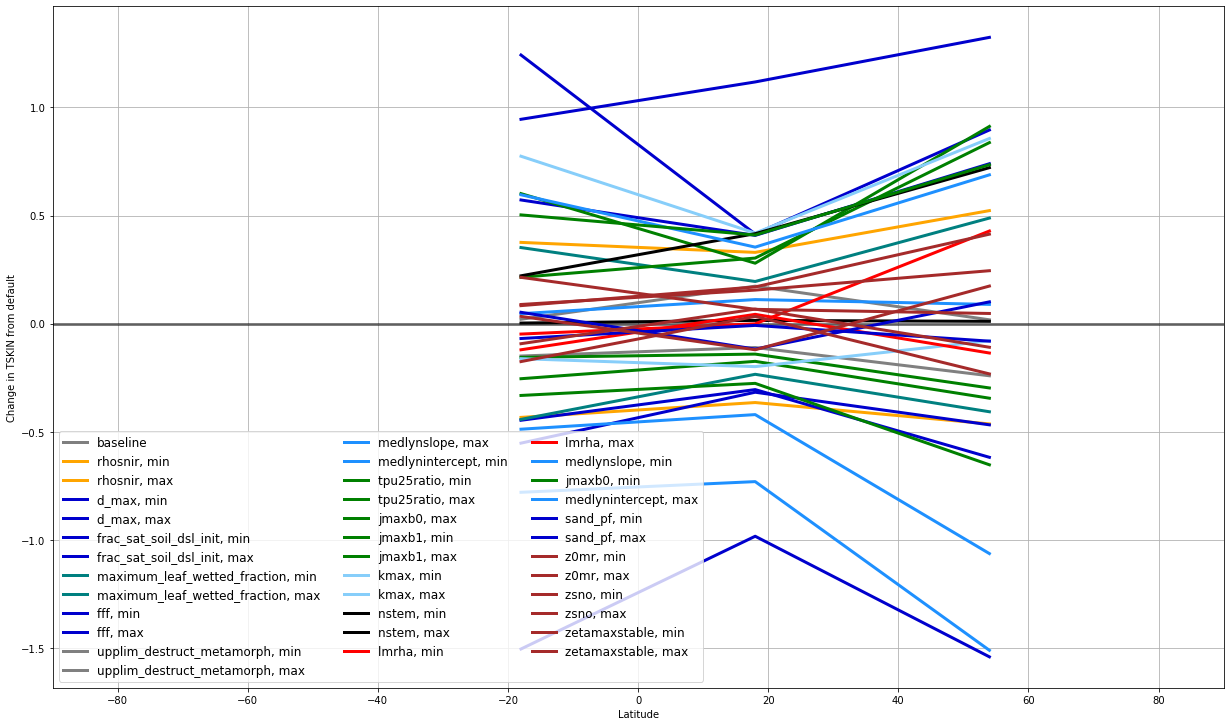

In [39]:
plt.figure(figsize=(17,10))
plt.plot([-90,90],[0,0],'-k',linewidth=3, alpha=0.5, label='baseline')
unitconv=1
for i in np.arange(0,len(ensemble_coupled)):
    ds=ensemble_coupled[i]
    tseries =get_tseries_mean(ds).mean(dim='year')
    avg=(tseries-ref_avg)*unitconv
    if i<=9:
        linestyle='-'
    elif i<=19:
        linestyle='--'
    elif i<=29:
        linestyle=':'
    elif i<=39:
        linestyle='-.'
    avgs=avg.where(landfrac>0.99).mean(dim='lon').load()
    plt.plot(avg.lat, avgs, 
             linestyle='-',#linestyle,
             linewidth=3,
             color=crosswalk_colors[i],
             label=crosswalk['description'].values[i])
    #print(avgs.values[-5])
    #plt.text(x=85,y=avgs[-5],
    #        s=crosswalk['description'].values[i])
plt.tight_layout()
plt.xlim([-90,90])
plt.legend(ncol=3, fontsize=12)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Change in '+var+' from default')
plt.savefig('Zonal_mean_'+var+'.png')

In [40]:
crosswalk_colors=['orange', 
                  'orange', 
                  'mediumblue', 
                  'mediumblue',
                  'mediumblue', 
                  'mediumblue',
                  'teal',
                  'teal', 
                  'mediumblue', 
                  'mediumblue',
                  'grey', 
                  'grey',
                  'dodgerblue', 
                  'dodgerblue', 
                  'green',
                  'green', 
                  'green', 
                  'green', 
                  'green',
                  'lightskyblue', 
                  'lightskyblue', 
                  'black', 
                  'black', 
                  'red',
                  'red', 
                  'dodgerblue', 
                  'green',
                  'dodgerblue',
                  'mediumblue',
                  'mediumblue',
                  'brown', 
                  'brown', 
                  'brown',
                  'brown',
                  'brown', 
                  'brown']

ValueError: x and y must have same first dimension, but have shapes (96,) and (6,)

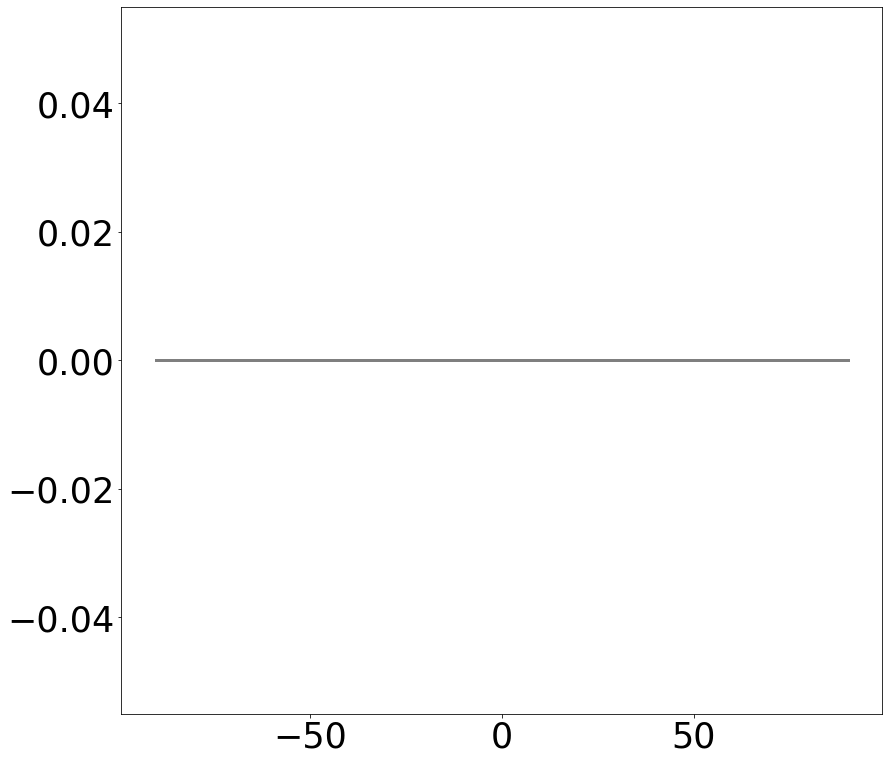

In [41]:
plt.figure(figsize=(30,13))
plt.rcParams.update({'font.size': 35})
focus_color='none'
lwidth=5

plt.subplot(1,2,1)
plt.plot([-90,90],[0,0],'-k',linewidth=3, alpha=0.5, label='baseline')
unitconv=1
for i in np.arange(0,len(ensemble_coupled)):
    ds=ensemble_coupled[i]
    [avg, p] =get_gridded_average(ds)
    avg=avg*unitconv
    if crosswalk_colors[i]==focus_color:
        plt.plot(avg.lat, avg.where(landfrac>0.5).mean(dim='lon'),  #
             linestyle='-',linewidth=lwidth,
                 color='green',#crosswalk_colors[i],#color='gray',
             label=crosswalk['description'].values[i])
    else:
        plt.plot(avg.lat, avg.where(landfrac>0.5).mean(dim='lon'), #
             linestyle='-',linewidth=lwidth,
                 color='gray',alpha=0.5,
             label=crosswalk['description'].values[i])
plt.tight_layout()
plt.xlim([-90,90])
plt.ylim([-15, 15])
#plt.legend(ncol=3, fontsize=12)
plt.grid()
plt.xlabel('Latitude')
plt.title('Land Only')
plt.ylabel('Change in '+var+' from default')

plt.subplot(1,2,2)
plt.plot([-90,90],[0,0],'-k',linewidth=3, alpha=0.5, label='baseline')
unitconv=1
for i in np.arange(0,len(ensemble_coupled)):
    ds=ensemble_coupled[i]
    [avg, p] =get_gridded_average(ds)
    avg=avg*unitconv
    avgs=avg.mean(dim='lon')
    print(crosswalk_colors[i])
    if crosswalk_colors[i]==focus_color:
        plt.plot(avg.lat, avgs, 
             linestyle='-',linewidth=lwidth,
                 color='green',#crosswalk_colors[i],#color='gray',
             label=crosswalk['description'].values[i])
    else:
        plt.plot(avg.lat, avgs, 
             linestyle='-',linewidth=lwidth, color='gray',alpha=0.5,
             label=crosswalk['description'].values[i])
plt.tight_layout()
plt.xlim([-90,90])
plt.ylim([-15, 15])
#plt.legend(ncol=3, fontsize=12)
plt.grid()
plt.xlabel('Latitude')
plt.title('Global (Land+Ocean)')
plt.ylabel('Change in '+var+' from default')

plt.tight_layout()

plt.savefig('Zonal_mean_'+var+'.png')

In [48]:
plt.figure(figsize=(17,10))
plt.plot([-90,90],[0,0],'-k',linewidth=3, alpha=0.5, label='baseline')
unitconv=1
for i in np.arange(0,len(ensemble_coupled)):
    ds=ensemble_coupled[i]
    [avg, p] =get_gridded_average(ds)
    avg=avg*unitconv
    if i<=9:
        linestyle='-'
    elif i<=19:
        linestyle='--'
    elif i<=29:
        linestyle=':'
    elif i<=39:
        linestyle='-.'
    avgs=avg.mean(dim='lon').load()
    plt.plot(avg.lat, avgs, 
             linestyle=linestyle,
             label=crosswalk['description'].values[i])
    print(avgs[-1]
    plt.text(x=90,y=avgs[-1],
            s=crosswalk['description'].values[i])
plt.tight_layout()
plt.xlim([-90,120])
plt.legend(ncol=3, fontsize=12)
plt.grid()
plt.xlabel('Latitude')
plt.ylabel('Change in '+var+' from default')
plt.savefig('Zonal_mean_'+var+'.png')

SyntaxError: invalid syntax (<ipython-input-48-561050ee7ed8>, line 21)